In [1]:
from pathlib import Path
import torch
from torch import nn,optim
from mltools import ld,draw

In [2]:
train_iter,val_iter,test_iter=ld.mnist('./data',batch_size=1000) # 获取训练集、验证集和测试集
# 设置模型结构
model=nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),nn.ReLU(),
    nn.Linear(256,10))
device=torch.device('cuda') # 设置设备
model_path='./model/MLP.pth'

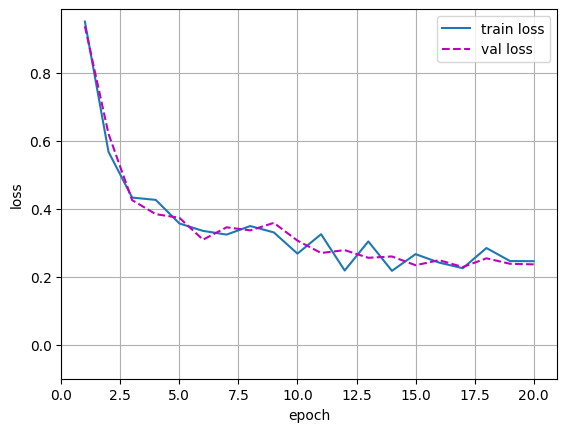

In [3]:
# 训练模型
def train(model,train_iter,val_iter,*,num_epochs,learing_rate,device):
    model.to(device) # 将网络复制到device上
    loss=nn.CrossEntropyLoss() # 定义损失函数
    optimizer=optim.SGD(model.parameters(),learing_rate) # 定义优化器
    animator=draw.Animator(line_num=2,xlabel='epoch',ylabel='loss',xlim=[0, num_epochs+1],ylim=-0.1,legend=['train loss','val loss'])
    for epoch in range(1,num_epochs+1):
        # 计算训练集
        for x,y in train_iter:
            # 运算
            x,y=x.to(device),y.to(device)
            y_train=model(x)
            train_loss=loss(y_train,y)
            # 梯度更新
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        # 计算验证集
        with torch.no_grad():
            for x,y in val_iter:
                # 运算
                x,y=x.to(device),y.to(device)
                y_val=model(x)
                val_loss=loss(y_val,y)
        animator.add(train_loss.detach().cpu(),val_loss.detach().cpu()) # 添加损失值

if Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    train(model,train_iter,val_iter,num_epochs=20,learing_rate=1e-1,device=device)
    torch.save(model.state_dict(), model_path)

In [4]:
# 测试模型
def test(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    test_num,real_num=0,0 # 定义测试数量和预测真实数量
    # 测试
    for x,y in test_iter:
        x,y=x.to(device),y.to(device)
        y_test=model(x).argmax(dim=1)
        pred=y==y_test
        test_num+=len(pred)
        real_num+=pred.sum()
    print(f'Accuracy rate {real_num/test_num}') # 计算测试准确率并输出
test(model,test_iter,device)

Accuracy rate 0.9336999654769897


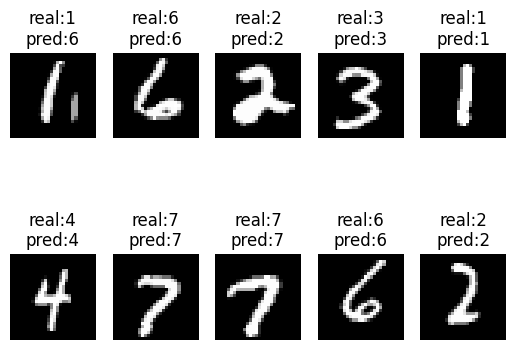

In [5]:
# 预测模型
def predict(model,test_iter,device):
    model.to(device) # 将网络复制到device上
    # 从测试中取一个批量
    x,y=next(iter(test_iter))
    x,y=x[:10].to(device),y[:10].to(device)
    # 预测
    y_pred=model(x).argmax(dim=1)
    labels=[f'real:{y[index]}\npred:{y_pred[index]}' for index in range(len(y))]
    # 输出样例图
    draw.images(x,labels,shape=(2,5))
predict(model,test_iter,device)